# Neural Networks With Estimators
In this notebook we recreate the neural network defined first in notebook [3.Neural-Networks.ipynb](3.Neural-Networks.ipynb)

## [Estimators](https://www.tensorflow.org/programmers_guide/estimators)

- High level TensorFlow API that encapsulates
    - Training
    - Testing
    - Prediction
    - Export for model serving
- Estimators are built on top of [tf.layers](https://www.tensorflow.org/tutorials/layers)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Tensorflow produces a lot of warnings. We generally want to suppress them. The below code does exactly that. 
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Parameters
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

- Two kinds of estimators
    - Pre-made built-in estimators: DNNClassifier, LinearRegressor
    - Custom estimators: written using Estimator API

<center><img src="img/estimator_types.png" alt="nn" style="width: 700px;"/></center>

### Benefits of Estimators

- Estimator-based models are independent of operating environment
    - local host
    - GPUs
    - CPU clusters

- Simplify model sharing between developers

- State of the art model architectures with more intuitive high-level code

- Built using tf.layers
- Estimators build TF Graph automatically given a series of layers

Please go through https://www.tensorflow.org/programmers_guide/estimators for more advantages of using Estimators as described by the developers of TensorFlow.

## Using the Estimator API 

### Estimator Workflow

- Define the model that uses an `input function`

- Specify additional calculations for:
    - Training
    - Prediction
    - Evaluation

### `input function`

   * Supplies data for training, evaluation, prediction
   * Should yield tuples of:
        - Python dict `features`: key = name of feature, value = array of feature values
        - Array `label` : label for every example

```python
def get_input_fn(mode):
    # Two seperate branches because of the differences in how we deal with the input data
    if mode == 'train':
        # When training, shuffling is OK
        return tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.train.images}, y=mnist.train.labels,
            batch_size=batch_size, num_epochs=None, shuffle=True)
    elif mode == "evaluation":
        # When testing, don't shuffle
        return tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.test.images}, y=mnist.test.labels,
            batch_size=batch_size, shuffle=False)
```

How the `input function` generates the `features` and `label` is up to the developer. 

TensorFlow developers recommend the use of the  TensorFlow's Dataset API. The Dataset API can parse in all kinds of data using a high level specification. This includes:
- reading lines from a file
- reading records from binary files
- iterators
- Initialize Dataset from  in-memory data

The Dataset API can even read in large files in parallel and join them into a single stream. It is highly versatile and should definitely be used when training from data that resides on the disk. 

For more information, refer: https://www.tensorflow.org/get_started/datasets_quickstart

* We used an inbuilt function [`tf.estimator.inputs.numpy_input_fn`](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/numpy_input_fn)

* Takes in Numpy arrays to return an input function.

In [4]:
#Executing the code described above
def get_input_fn(mode):
    # We need two seperate branches because of differences in how we deal with the input data
    if mode == 'train':
        # When training, shuffling is OK, num_epochs denotes how many times to go over the training data
        return tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.train.images}, y=mnist.train.labels,
            batch_size=batch_size, num_epochs=None, shuffle=True)
    elif mode == "evaluation":
        # When testing, don't shuffle
        # Default value for num_epochs is 1; we only want to go over the test set once
        return tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.test.images}, y=mnist.test.labels,
            batch_size=batch_size, shuffle=False)

#### Create Feature Columns

If we had read the data from files, we need to create feature columns that describe how to use the input. 

Is it numeric? Categorical? 

We can skip this step because we are using example data that is already pre-processed.

### Define the Model Function 

- Model function is the beating heart of Estimator

- Has the following signature:
```python
def my_model_fn(
       features, # This is batch_features from input_fn
       labels,   # This is batch_labels from input_fn
       mode,     # An instance of tf.estimator.ModeKeys
       params):  # Additional configuration
```

`ModeKeys` specify whether the model is being called for training, evaluation or prediction. 

This is useful for neural network architectures that vary between training and prediction, such as for models that make use of dropout.

Defining a neural network function to use later
- Input: feature dict
- Output: Array of 10 logits 

In [5]:
# Creating the NN without estimators or layers
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    with tf.name_scope('Layer1'):
        layer_1 = tf.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 256 neurons
    with tf.name_scope('Layer2'):
        layer_2 = tf.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer with a neuron for each class
    with tf.name_scope('Logits'):
        out_layer = (tf.matmul(layer_2, weights['out']) + biases['out'])
    return out_layer

# Creating the NN with estimators and layers
def neural_net(x_dict):
    # in case of multiple inputs, TF Estimator's input has to be a dict 
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

When using the Estimator API, it is recommended to use mid-level APIs such as Layers and Metrics in order to simplify the specification of our model. 

Fully connected hidden layers are implemented in `tf.layers` as a `Dense` layer. 

The Dense layer takes as input an incoming tensor, and the number of nodes in the Dense layer that we are specifying. 

Benefits of high level API:
- Can encapsulate calculations as pre-defined layers. <br>Other layers include:
    - Convolution
    - Dropout
    - Pooling

In [6]:
# Define and adding the neural network to the TensorGraph
def neural_net(x_dict):
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

### Implementing the Model function

First, prepare the output and predictions

```python
# Build the neural network
logits = neural_net(features)
# Predictions
pred_classes = tf.argmax(logits, axis=1)
pred_probabilties = tf.nn.softmax(logits)
```

The model function should return an instance of `tf.estimator.EstimatorSpec`.

This can be instantiated by:
```python
class EstimatorSpec(
    collections.namedtuple('EstimatorSpec', [
        'mode', 'predictions', 'loss', 'train_op', 'eval_metric_ops',
        'export_outputs', 'training_chief_hooks', 'training_hooks', 'scaffold',
        'evaluation_hooks'
    ])):
```

If we are only interested in prediction or inference from the neural network, we do not need to backpropagate errors. 

In a real out-of-lab environment, we would not even have the actual labels to calculate errors and backpropagate errors through the gradients. 

In this case, we do not require the backpropagation part of the TF Graph. We can return an EstimatorSpec as soon as we make our predictions. 

For more complex DNN's there may be different model architectures for training as compared to evaluation or prediction. It is important to fully account for these cases in the specification of our model function by handling the branching cases. An example of a more complex DNN is a DNN that uses dropout layers.

### **Handle branches**

- `mode` = Prediction
```python
if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
```

Else
- `mode` = Training and Evaluation

``` python
estim_specs = tf.estimator.EstimatorSpec(
  mode=mode,
  predictions=pred_classes,
  loss=loss_op,
  train_op=train_op,
  eval_metric_ops={'accuracy': acc_op})

return estim_specs
```


In [7]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    
    logits = neural_net(features)

    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, return early
    if mode == tf.estimator.ModeKeys.PREDICT:
        # return EstimatorSpec that would be only used for prediction
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Else we are training and evaluating 
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step = tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators should return an EstimatorSpec
    # specifying the different ops for training, predicting
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

### Build and Use the Estimator


In [8]:
model = tf.estimator.Estimator(model_fn)

### Train the Model
 

The model can be trained using the Estimator's `train` function

In [9]:
# We do not need to start a tf.session!
input_fn = get_input_fn('train')
model.train(input_fn, steps=num_steps)

### Evaluate the Model

The model can be trained using the Estimator's `evaluate` function

Remember, we need the evaluation input function when we test our model

In [10]:
# Again, we do not need to explicitly start a tf.session! 
evaluate_input_fn = get_input_fn('evaluation')
model.evaluate(evaluate_input_fn)

{'accuracy': 0.9207, 'global_step': 1000, 'loss': 0.28952935}

### Predict using the Model 

Model predictions are  [7, 2]
Model predictions are  [1, 0]


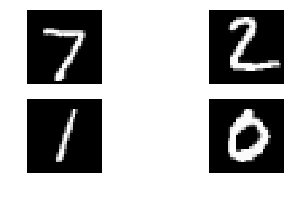

In [11]:
n_images = 4

actual_labels = mnist.test.images[:n_images]
predictions = list(model.predict(evaluate_input_fn))

# Display
f = plt.figure(figsize=(6,3))
for i in range(n_images):
    sp = f.add_subplot(2, 2, i+1)
    sp.axis('Off')
    plt.imshow(np.reshape(actual_labels[i], [28, 28]), cmap='gray')
print('Model predictions are ' ,predictions[:2])
print('Model predictions are ' ,predictions[2:4])